In [40]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score,accuracy_score, precision_score,recall_score, roc_curve, auc,classification_report
from sklearn.inspection import DecisionBoundaryDisplay

from keras.datasets import cifar10

import warnings
warnings.filterwarnings('ignore')

60000 images total. We have 10,000 testing images and 50,000 images for training. We further split the 50,000 images into 40,000 images for training and 10,000 images for validation

In [70]:
(X_tr, y_tr), (X_te, y_te) = cifar10.load_data()
seed = 1234 # for reproduction
# Concatenate train and test images
X = np.concatenate((X_tr,X_te))
y = np.concatenate((y_tr,y_te))
# Randomization
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=10000, random_state=seed,shuffle=True)
# size of X_tr = (50000,32,32,3) where (32,32) is size of the image and (3) is red,green,and blue channel values.
# we have 50000 datapoints for training set, and each set will have 32*32*3 = 3072 features. we need to reshape for training 
X_tr = X_tr.reshape(50000,3072)
X_te = X_te.reshape(10000,3072)
y_tr = y_tr.reshape(50000)
y_te = y_te.reshape(10000)

#X_tr_lc is training set with 50000 datapoints for model.selection.learning_curve
X_tr_lc = X_tr
y_tr_lc = y_tr


In [71]:
# Validation sets
X_val = X_tr[40000:50000]
y_val = y_tr[40000:50000]
# Training sets
X_tr = X_tr[:40000]
y_tr = y_tr[:40000]
print(X_tr.shape)
print(y_tr.shape)

(40000, 3072)
(40000,)


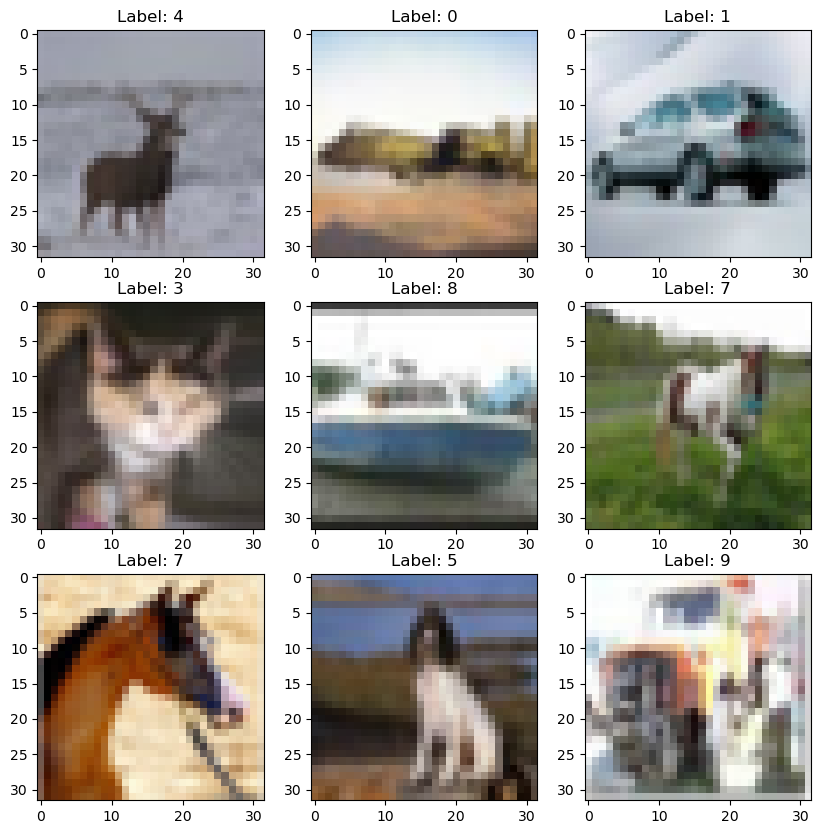

In [4]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10)) 

for i in range(9):
    img = X_tr[i]
    axes[i//3, i%3].imshow(img.reshape(32,32,3)) # to show the image, we have to convert 3072 features back to (32,32,3)
    label = y_tr[i] 
    axes[i//3, i%3].set_title(f'Label: {label}') 

In [73]:
# Reshape fit and transform the data for better results
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr)
X_te = scaler.transform(X_te)
X_val = scaler.transform(X_val)
X_tr_lc = scaler.transform(X_tr_lc)
#Take smaller size of training set for better runtime
#X_tr = X_tr[:5000]
#y_tr = y_tr[:5000]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


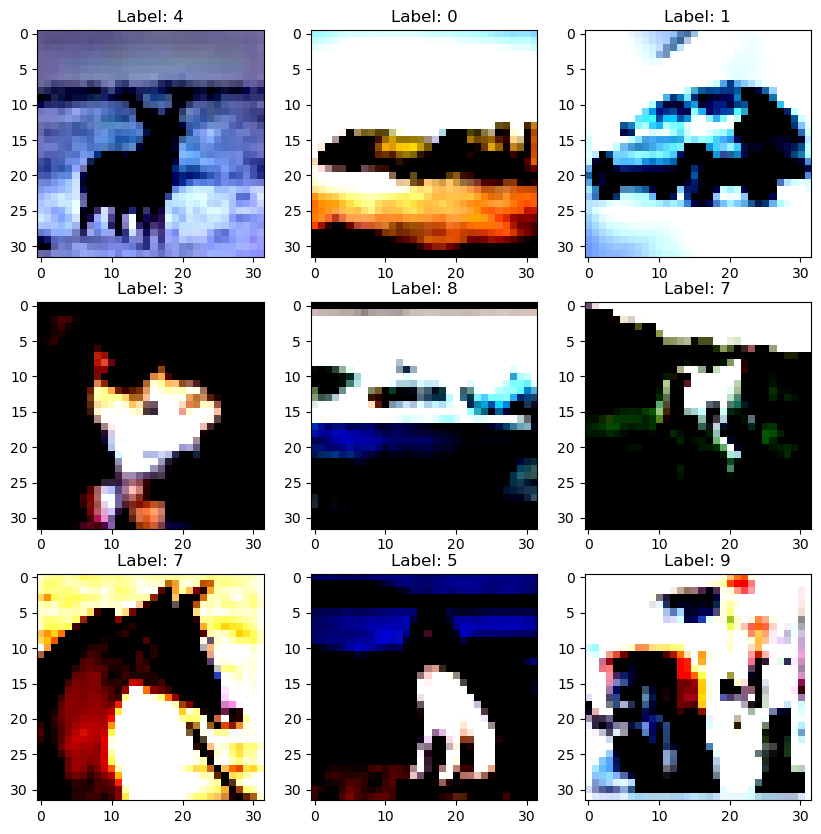

In [6]:
#plot scaled images
fig, axes = plt.subplots(3, 3, figsize=(10, 10)) 

for i in range(9):
    img = X_tr[i]
    axes[i//3, i%3].imshow(img.reshape(32,32,3)) # to show the image, we have to convert 3072 features back to (32,32,3)
    label = y_tr[i] 
    axes[i//3, i%3].set_title(f'Label: {label}') 

1. KNN Classifier

In [32]:
#KNN
val_error_list = []
te_error_list = []
tr_error_list = []
max_accuracy_index = 0
max_accuracy = 0
best_k_test_accuracy = 0
i = 0
#different hyper parameters
k_list = [3,5,7,9,11,13,15,25,50,100,250,500,750,1000,1250,1500,2000,2500,3000]
for k in k_list:
    knn = KNeighborsClassifier(n_neighbors=k).fit(X_tr, y_tr)
    # Accuracy/error
    val_accuracy = knn.score(X_val,y_val)
    val_error = 1 - val_accuracy
    te_accuracy = knn.score(X_te,y_te)
    te_error = 1-te_accuracy
    tr_accuracy = knn.score(X_tr,y_tr)
    tr_error = 1-tr_accuracy

    val_error_list.append(val_error)
    te_error_list.append(te_error)
    tr_error_list.append(tr_error)
    #determine the best k's index 
    if i == 0:
        max_accuracy = val_accuracy
        best_k_test_accuracy = te_accuracy
    else:
        if(max_accuracy<val_accuracy):
            max_accuracy = val_accuracy
            max_accuracy_index = i
            best_k_test_accuracy = te_accuracy
    i+=1
#end for

best_k = k_list[max_accuracy_index]
print("best k is:", best_k,"accuracy on testing set is ", best_k_test_accuracy)

best k is: 7 accuracy on testing set is  0.3326


In [68]:
# plot graphs for best_k
knn = KNeighborsClassifier(n_neighbors=best_k).fit(X_tr, y_tr)

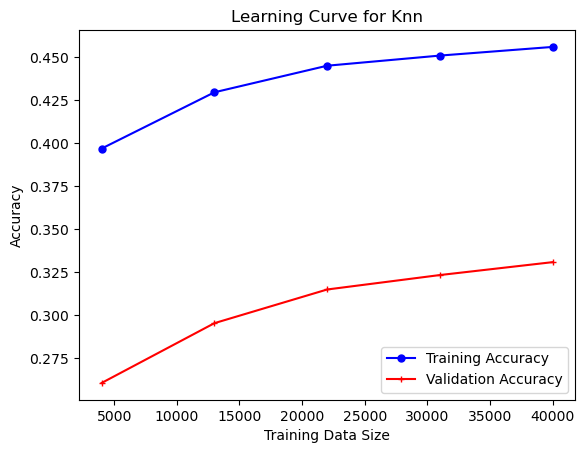

In [9]:
fig, axes = plt.subplots()
#Learning Curve
train_sizes, train_scores, test_scores = learning_curve(estimator=knn, X=X_tr_lc, y=y_tr_lc,n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
axes.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
axes.plot(train_sizes, test_mean, color='red', marker='+', markersize=5, label='Validation Accuracy')
axes.set_title('Learning Curve for Knn')
axes.set_xlabel('Training Data Size')
axes.set_ylabel('Accuracy')
axes.legend(loc='lower right')

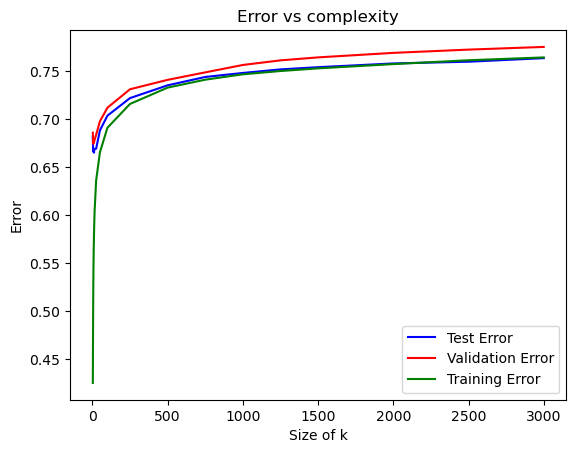

In [33]:
fig, axes = plt.subplots()
#Error vs complexity tradeoffs
axes.plot(k_list, te_error_list, color='blue',  label='Test Error')
axes.plot(k_list, val_error_list, color='red',  label='Validation Error')
axes.plot(k_list, tr_error_list, color='green',  label='Training Error')
axes.set_title('Error vs complexity')
axes.set_xlabel('Size of k')
axes.set_ylabel('Error')
axes.legend(loc='lower right')

In [21]:
#roc_auc_scores for testing set and classfication report
y_te_scores = knn.predict_proba(X_te)
print('Testing set roc_auc_score: %.5f'% roc_auc_score(y_te,y_te_scores, average='macro',multi_class='ovr'))
print(classification_report(y_te, knn.predict(X_te)))

Testing set roc_auc_score: 0.74307
              precision    recall  f1-score   support

           0       0.40      0.54      0.46       986
           1       0.74      0.18      0.29      1018
           2       0.23      0.43      0.30      1005
           3       0.31      0.24      0.27      1023
           4       0.22      0.51      0.30      1004
           5       0.46      0.21      0.28      1024
           6       0.34      0.26      0.29      1006
           7       0.68      0.19      0.30       951
           8       0.38      0.68      0.49       992
           9       0.70      0.09      0.17       991

    accuracy                           0.33     10000
   macro avg       0.45      0.33      0.32     10000
weighted avg       0.45      0.33      0.32     10000



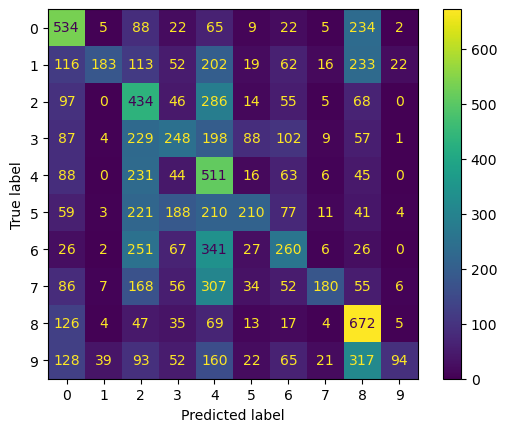

In [22]:
#Confusion Matrix for the best k
y_te_pred = knn.predict(X_te)
sklearn_cm = confusion_matrix(y_te, y_te_pred)
sklearn_disp = ConfusionMatrixDisplay(confusion_matrix = sklearn_cm)
sklearn_disp.plot()

In [86]:
#Insepction/Decision Boundaries

print(X_tr.shape)
DecisionBoundaryDisplay.from_estimator(knn, X_tr[1,:])



(40000, 3072)


ValueError: 'X' should be a 2D NumPy array, 2D sparse matrix or pandas dataframe when indexing the columns (i.e. 'axis=1'). Got <class 'numpy.ndarray'> instead with 1 dimension(s).

2.Logistic Regression

Accuracy: 0.28680
Precision: 0.28845
Recall: 0.28723
roc_auc_score: 0.72131


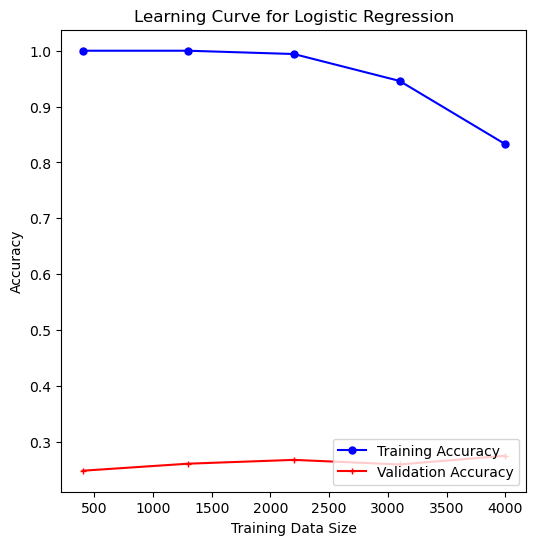

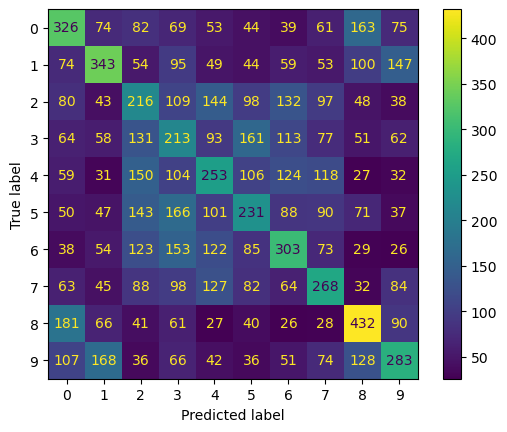

In [30]:
#Logistic Regression

fig, axes = plt.subplots(figsize=(6, 6))
lr = LogisticRegression(random_state=seed).fit(X_tr, y_tr)
#Confusion Matrix
y_te_pred = lr.predict(X_te)
sklearn_cm = confusion_matrix(y_te, y_te_pred)
sklearn_disp = ConfusionMatrixDisplay(confusion_matrix = sklearn_cm)
sklearn_disp.plot()
# Accuracy, Precision, Recall, ROC AUC score
y_te_scores = lr.predict_proba(X_te)
print('Accuracy: %.5f' % accuracy_score(y_te, y_te_pred))
print('Precision: %.5f' % precision_score(y_te, y_te_pred,average='macro'))
print('Recall: %.5f' % recall_score(y_te, y_te_pred,average='macro'))
print('roc_auc_score: %.5f'% roc_auc_score(y_te,y_te_scores, average='macro',multi_class='ovr'))

#Learning Curve
train_sizes, train_scores, test_scores = learning_curve(estimator=lr, X=X_tr, y=y_tr,n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

axes.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
axes.plot(train_sizes, test_mean, color='red', marker='+', markersize=5, label='Validation Accuracy')
axes.set_title('Learning Curve for Logistic Regression')
axes.set_xlabel('Training Data Size')
axes.set_ylabel('Accuracy')
axes.legend(loc='lower right')



3.Neural Network

Accuracy: 0.37240
Precision: 0.37672
Recall: 0.37321
roc_auc_score: 0.79068


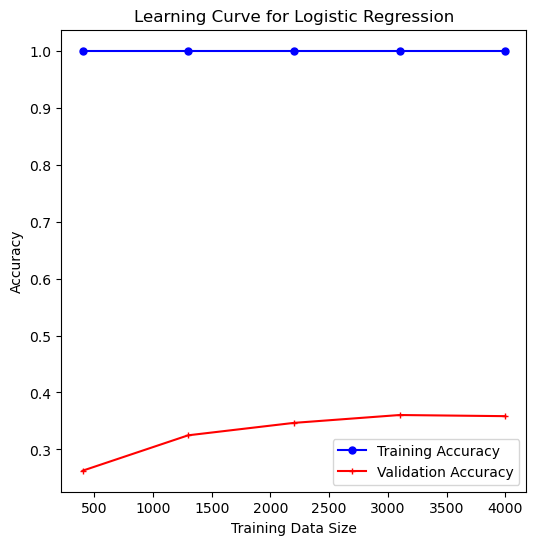

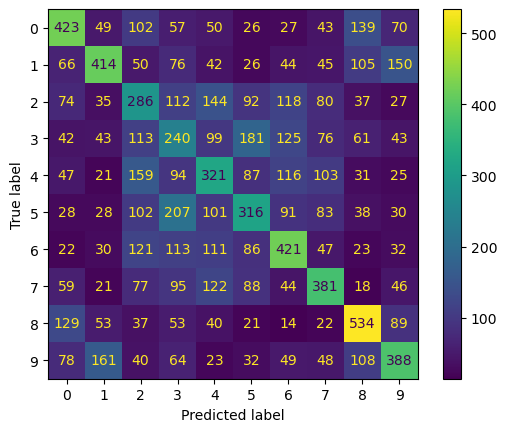

In [32]:
#Neural Network

fig, axes = plt.subplots(figsize=(6, 6))
clf = MLPClassifier(hidden_layer_sizes=(64,),activation = 'relu',n_iter_no_change=100,
                    solver='sgd',max_iter=100, learning_rate_init = 0.01, batch_size=256,random_state=seed).fit(X_tr, y_tr)
#Confusion Matrix
y_te_pred = clf.predict(X_te)
sklearn_cm = confusion_matrix(y_te, y_te_pred)
sklearn_disp = ConfusionMatrixDisplay(confusion_matrix = sklearn_cm)
sklearn_disp.plot()
# Accuracy, Precision, Recall, ROC AUC score
y_te_scores = clf.predict_proba(X_te)
print('Accuracy: %.5f' % accuracy_score(y_te, y_te_pred))
print('Precision: %.5f' % precision_score(y_te, y_te_pred,average='macro'))
print('Recall: %.5f' % recall_score(y_te, y_te_pred,average='macro'))
print('roc_auc_score: %.5f'% roc_auc_score(y_te,y_te_scores, average='macro',multi_class='ovr'))

#Learning Curve
train_sizes, train_scores, test_scores = learning_curve(estimator=clf, X=X_tr, y=y_tr,n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

axes.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
axes.plot(train_sizes, test_mean, color='red', marker='+', markersize=5, label='Validation Accuracy')
axes.set_title('Learning Curve for Logistic Regression')
axes.set_xlabel('Training Data Size')
axes.set_ylabel('Accuracy')
axes.legend(loc='lower right')


4.Decision tree

In [38]:
#Decision Tree
val_error_list = []
te_error_list = []
tr_error_list = []
max_accuracy_index = 0
max_accuracy = 0
best_depth_test_accuracy = 0
i = 0
#different hyper parameters
depth_list = [3,4,5,6,7,8,9,10,11,12,13,14,15]
for d in depth_list:
    dtc = DecisionTreeClassifier(max_depth = d,random_state=seed).fit(X_tr, y_tr)
    # Accuracy/error
    val_accuracy = dtc.score(X_val,y_val)
    val_error = 1 - val_accuracy
    te_accuracy = dtc.score(X_te,y_te)
    te_error = 1-te_accuracy
    tr_accuracy = dtc.score(X_tr,y_tr)
    tr_error = 1-tr_accuracy

    val_error_list.append(val_error)
    te_error_list.append(te_error)
    tr_error_list.append(tr_error)
    #determine the best depth's index 
    if i == 0:
        max_accuracy = val_accuracy
        best_depth_test_accuracy = te_accuracy
    else:
        if(max_accuracy<val_accuracy):
            max_accuracy = val_accuracy
            max_accuracy_index = i
            best_depth_test_accuracy = te_accuracy
    i+=1
#end for

best_depth = depth_list[max_accuracy_index]
print("best depth is:", best_depth,"accuracy on testing set is ", best_depth_test_accuracy)

best depth is: 10 accuracy on testing set is  0.2958


In [24]:
dtc = DecisionTreeClassifier(max_depth = best_depth,random_state=seed).fit(X_tr, y_tr)

[Text(0.4990129116766467, 0.9545454545454546, 'X[80] <= 0.235\ngini = 0.9\nsamples = 40000\nvalue = [4017, 3917, 3990, 4028, 4045, 3918, 3998, 4042, 4003\n4042]'),
 Text(0.24726796407185628, 0.8636363636363636, 'X[1400] <= 0.528\ngini = 0.886\nsamples = 22810\nvalue = [1112, 2155, 2761, 2832, 3244, 3035, 3271, 2208, 1064\n1128]'),
 Text(0.12326908682634731, 0.7727272727272727, 'X[2473] <= -0.922\ngini = 0.876\nsamples = 17066\nvalue = [628, 1214, 2310, 2168, 2865, 2011, 2878, 1631, 579\n782]'),
 Text(0.05858907185628742, 0.6818181818181818, 'X[2554] <= -1.274\ngini = 0.88\nsamples = 3408\nvalue = [121, 554, 347, 520, 247, 320, 574, 229, 169, 327]'),
 Text(0.028854790419161676, 0.5909090909090909, 'X[1599] <= 0.724\ngini = 0.859\nsamples = 1128\nvalue = [43, 310, 91, 131, 61, 82, 124, 65, 80, 141]'),
 Text(0.016841317365269462, 0.5, 'X[2591] <= -1.029\ngini = 0.875\nsamples = 928\nvalue = [37, 209, 89, 121, 58, 76, 107, 60, 63, 108]'),
 Text(0.009431137724550898, 0.4090909090909091, 'X[

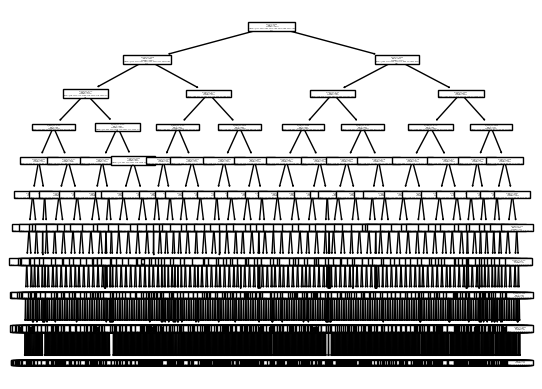

In [ ]:
#plot tree for visulization
plot_tree(dtc)

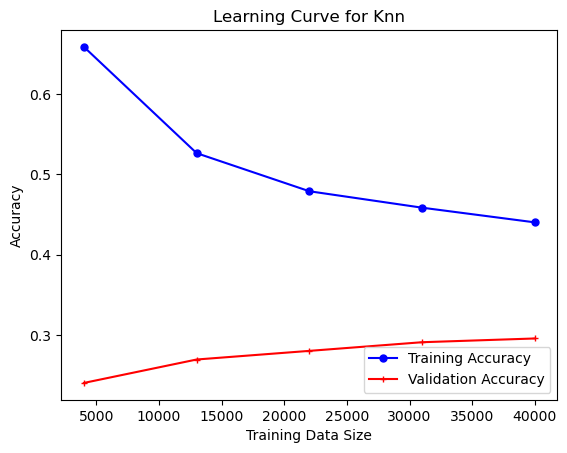

In [ ]:
fig, axes = plt.subplots()
#Learning Curve
train_sizes, train_scores, test_scores = learning_curve(estimator= dtc, X=X_tr_lc, y=y_tr_lc,n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
axes.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
axes.plot(train_sizes, test_mean, color='red', marker='+', markersize=5, label='Validation Accuracy')
axes.set_title('Learning Curve for decision tree')
axes.set_xlabel('Training Data Size')
axes.set_ylabel('Accuracy')
axes.legend(loc='lower right')

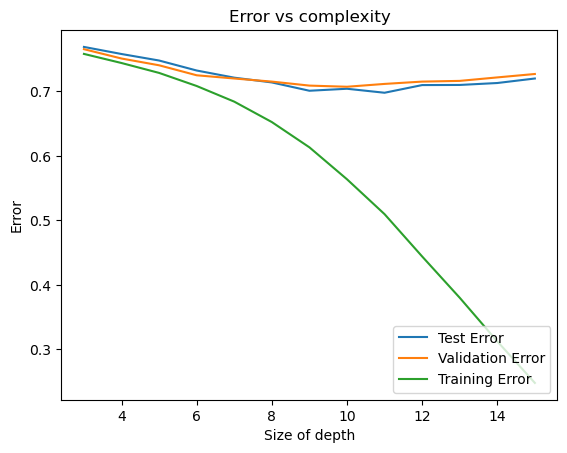

In [39]:
fig, axes = plt.subplots()
#Error vs complexity tradeoffs
axes.plot(depth_list, te_error_list,  label='Test Error')
axes.plot(depth_list, val_error_list, label='Validation Error')
axes.plot(depth_list, tr_error_list,  label='Training Error')
axes.set_title('Error vs complexity')
axes.set_xlabel('Size of depth')
axes.set_ylabel('Error')
axes.legend(loc='lower right')

In [30]:
#roc_auc_scores for testing set and classfication report
y_te_scores = dtc.predict_proba(X_te)
print('Testing set roc_auc_score: %.5f'% roc_auc_score(y_te,y_te_scores, average='macro',multi_class='ovr'))
print(classification_report(y_te, knn.predict(X_te)))

Testing set roc_auc_score: 0.62445
              precision    recall  f1-score   support

           0       0.40      0.54      0.46       986
           1       0.74      0.18      0.29      1018
           2       0.23      0.43      0.30      1005
           3       0.31      0.24      0.27      1023
           4       0.22      0.51      0.30      1004
           5       0.46      0.21      0.28      1024
           6       0.34      0.26      0.29      1006
           7       0.68      0.19      0.30       951
           8       0.38      0.68      0.49       992
           9       0.70      0.09      0.17       991

    accuracy                           0.33     10000
   macro avg       0.45      0.33      0.32     10000
weighted avg       0.45      0.33      0.32     10000



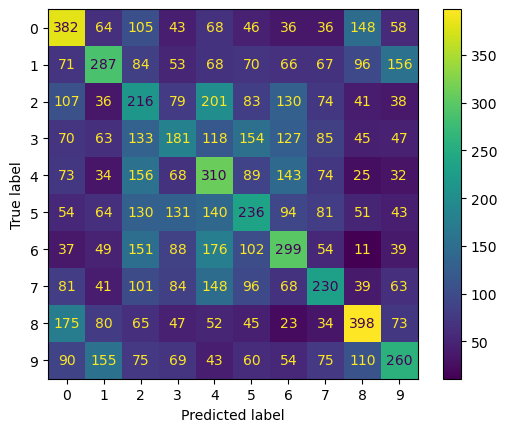

In [31]:
#Confusion Matrix
y_te_pred = dtc.predict(X_te)
sklearn_cm = confusion_matrix(y_te, y_te_pred)
sklearn_disp = ConfusionMatrixDisplay(confusion_matrix = sklearn_cm)
sklearn_disp.plot()